In [2]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import time
import h5py

#ktis19 modules
from starter_code.visualize import visualize
from starter_code.utils import load_case

#own modules
    #architecture of network
from modules.NeuralNetwork import makeModel, dice_coef_loss, dice_coef
    #simple matplotlib visualizer with slider
from modules.visualizeSlider import cube_show_slider
    #preprocessing for data 
    #REDUNDANT - USED ONLY IN DATA GENERATORS
from modules.preprocessing import preprocess_X, preprocess_y, scale
    #data flow generators
from modules.dataGenerators import trainGenerator, validationGenerator

# changing to half precision due to memory limitations
# import tf.keras.backend as K
# K.set_floatx('float16')
# K.set_epsilon(1e-4)

In [3]:
case_numbers = np.delete(np.arange(0, 209, 1), [158, 159, 170, 202])
case_numbers_val = case_numbers[149:]
case_numbers_train = case_numbers[:149]

In [4]:
slices_val = []
for case_num in tqdm(case_numbers_val):
    volume, segmentation = load_case(case_num)
    y, begin, end = preprocess_y(segmentation)
    slices_val.append(y[begin:end+1, :, :].shape[0])
print(np.sum(slices_val))

100%|██████████| 56/56 [01:56<00:00,  2.08s/it]3547



In [5]:
slices_train = []
for case_num in tqdm(case_numbers_train):
    volume, segmentation = load_case(case_num)
    y, begin, end = preprocess_y(segmentation)
    slices_train.append(y[begin:end+1, :, :].shape[0])
print('\n', np.sum(slices_train))

100%|██████████| 149/149 [05:06<00:00,  2.06s/it]
 12009




 14290


In [3]:

hf = h5py.File('data\\data.h5', 'w')
for case_num in tqdm(case_numbers):
    volume, segmentation = load_case(case_num)
    X = volume.get_fdata()
    y = segmentation.get_fdata()
    start_time = time.time()
    hf.create_dataset('X_{}'.format(case_num), data=X, compression="gzip")
    hf.create_dataset('y_{}'.format(case_num), data=y, compression="gzip")    
    print('saved case in {:2f}s'.format(time.time() - start_time))
hf.close()

  0%|          | 1/205 [01:09<3:57:05, 69.73s/it]


KeyboardInterrupt: 

In [74]:
hf.close()

In [4]:
def minMax(array):
    return (array - np.min(array))/(np.max(array) - np.min(array))

In [9]:
volume, segmentation = load_case(200)
X = preprocess_X(volume)
model = tf.keras.models.load_model(r'MODEL.h5', custom_objects={
    'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
segmentation_pred = model.predict(X)


In [18]:
segmentation_pred[:, :, :, 1].dtype

dtype('float32')

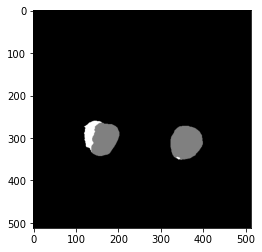

In [32]:
img = minMax(segmentation_pred[:, :, :, 2])
cancer = cv2.threshold(img,0.8,1,cv2.THRESH_BINARY)[1][40,:,:]
img = minMax(segmentation_pred[:, :, :, 1])
kidney = cv2.threshold(img,0.2,1,cv2.THRESH_BINARY)[1][40,:,:]
seg = np.clip((kidney + cancer*2), 0, 2)

plt.imshow(seg, cmap='gray')

In [18]:
segmentation_pred_cancer = cv2.adaptiveThreshold(
minMax(segmentation_pred[:, :, :, 1]),1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1647: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::adaptiveThreshold'


In [70]:
start_time = time.time()
X = hf.get('X_123')
sum = np.sum(X)
print(time.time() - start_time)


1.9940011501312256


loaded and slices case 123 in 6.285044s
yielding in 0.0s
iter  0


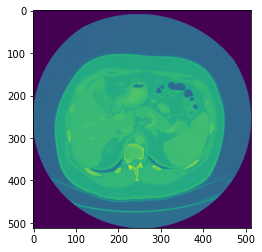

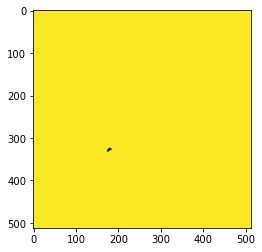

x.shape: (25, 512, 512, 1)
y.shape: (25, 512, 512, 3)
X data range: 0.0 to 0.7882783882783883
y data range: 0.0 to 1.0
yielding in 0.0s
iter  1


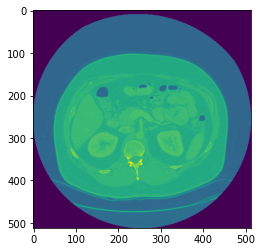

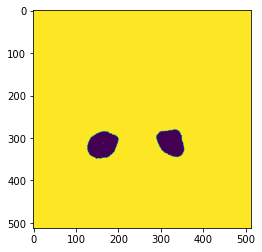

x.shape: (25, 512, 512, 1)
y.shape: (25, 512, 512, 3)
X data range: 0.0 to 0.787057387057387
y data range: 0.0 to 1.0
yielding in 0.0s
iter  2


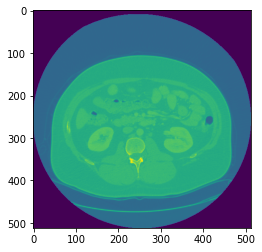

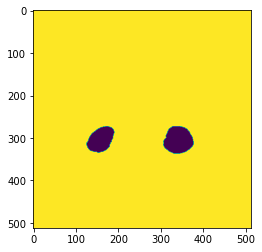

x.shape: (25, 512, 512, 1)
y.shape: (25, 512, 512, 3)
X data range: 0.0 to 0.789010989010989
y data range: 0.0 to 1.0
yielding in 0.0s
iter  3


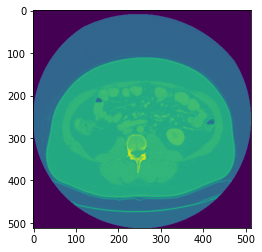

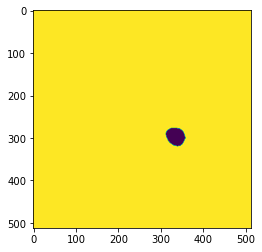

x.shape: (10, 512, 512, 1)
y.shape: (10, 512, 512, 3)
X data range: 0.0 to 0.788034188034188
y data range: 0.0 to 1.0
loaded and slices case 123 in 6.406000s
yielding in 0.0s
iter  4


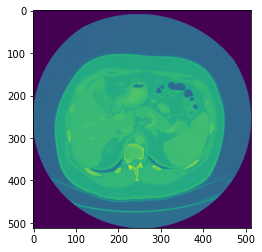

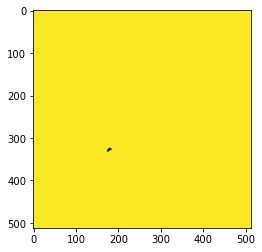

x.shape: (25, 512, 512, 1)
y.shape: (25, 512, 512, 3)
X data range: 0.0 to 0.7882783882783883
y data range: 0.0 to 1.0
yielding in 0.0s
iter  5


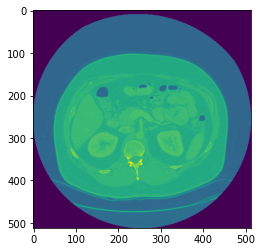

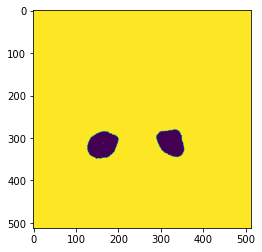

x.shape: (25, 512, 512, 1)
y.shape: (25, 512, 512, 3)
X data range: 0.0 to 0.787057387057387
y data range: 0.0 to 1.0


In [2]:
c = 0
for x, y, t in trainGenerator([123], 25):
  print('iter ', c)
  plt.imshow(x[0,:,:,0])
  plt.show()
  plt.imshow(y[0,:,:,0])
  plt.show()
  print('x.shape:', x.shape)
  print('y.shape:', y.shape)  
  print('X data range:', np.min(x), 'to', np.max(x))
  print('y data range:', np.min(y), 'to', np.max(y))
  c += 1
  if c > 5:
    break

In [11]:
NAME = 13
epoch = 7
val_loss = 0.002
print('saved_models/{}/model.{:02d}-{:.4f}.h5'.format(NAME, epoch, val_loss))

saved_models/13/model.07-0.0020.h5


(array([106.,  23.,  16.,   4.,   8.,   9.,   9.,   2.,   0.,   2.]),
 array([  29.,  132.,  235.,  338.,  441.,  544.,  647.,  750.,  853.,
         956., 1059.]),
 <a list of 10 Patch objects>)

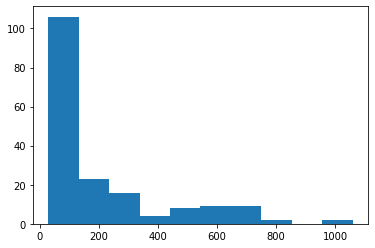

In [2]:
%matplotlib inline
heights = np.loadtxt('heights_train.txt')
plt.hist(heights)

In [21]:
tf.convert_to_tensor(X, dtype=tf.float16)

ValueError: TypeError: object of type 'ArrayProxy' has no len()


In [12]:
start_time = time.time()
volume, segmentation = load_case(123)
print("loaded data %s s" % (time.time() - start_time))

X = volume.dataobj
y = segmentation.dataobj
loaded_time = time.time()
print("turned into arrays %s s" % (time.time() - start_time))
y_slices=len(y[:,0,0])-1
for slice in range(y_slices):
    print('ups')
    if tf.keras.backend.sum(y[slice,:,:])>0:        
        begining_slice=slice
        break
for slice in range(y_slices):
    if np.sum(y[(y_slices-slice),:,:])>0:
        ending_slice=y_slices-slice
        break
print("scaned for segmentation %s s" % (time.time() - start_time))
print('total case slices: ', y_slices)
print('begining slice: ', begining_slice)
print('ending slice: ', ending_slice)
print('data reduced to: {:2f}% in {:4f} seconds'.format(((ending_slice-begining_slice)/y_slices)*100, time.time() - loaded_time))

loaded data 0.003001689910888672 s
turned into arrays 0.003001689910888672 s
ups
ups
ups
ups
ups
ups


KeyboardInterrupt: 

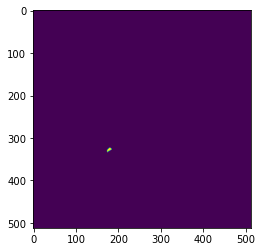

In [26]:
plt.imshow(y[90:96,:,:][-1])

In [4]:
# np.max(y)

In [5]:
# %matplotlib qt
# cube_show_slider(cube=y[:,:,:,1], axis=0, cmap='gray')

In [6]:
# def dice_score(y_true, y_pred):
#     numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
#     denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
#     return 1/(1 - numerator / denominator)

# def iou_loss_core(true,pred):  
#     intersection = true * pred
#     notTrue = 1 - true
#     union = true + (notTrue * pred)
#     return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

In [18]:
X, y = next(trainGenerator(case_numbers_train, 200))

In [20]:
cube_show_slider(cube=X[:,:,:,0], axis=0, cmap='gray')

In [7]:
model = makeModel(512, 512, 1)

0-179 Train set, 180-209 val_set, 210-299 test

AMOUNT OF SLICES FOR TRAIN DATA == 38650

AMOUNT OF SLICES FOR VALID DATA == 4520

In [ ]:
NAME = "unet_without_edge_detection_with_batch_norm_{}".format(int(time.time()))
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))]


In [6]:
(case_numbers_val[0]-np.min(case_numbers_val))/(np.max(case_numbers_val)-np.min(case_numbers_val))

0.0

In [ ]:
batch_size = 8
data_size = 38650
val_data_size = 4520
results = model.fit(
    trainGenerator(case_numbers_train, batch_size),
    steps_per_epoch = int(np.floor( data_size / (batch_size) )),
    epochs = 4,
    callbacks = callbacks,
    verbose = 1,
    validation_data = validationGenerator(case_numbers_val, batch_size),
    validation_steps = int(np.floor( val_data_size / (batch_size) ))
    )

In [ ]:
model.save('saved_models\model_big_5')

In [3]:
model = tf.keras.models.load_model('saved_models\model_big_6', custom_objects={'soft_dice_loss': soft_dice_loss})

In [4]:
volume, segmentation = load_case(123)
X = preprocess_X(volume)
y = preprocess_y(segmentation)

In [5]:
predicted = model.predict(X)
def dice_score(y_pred, y_test):
    return np.sum(y_pred)*2.0 / (np.sum(y_pred) + np.sum(y_test))

dice_score(predicted[:,:,:,1], y[:,:,:,1])

1.7600154820218787

In [6]:
results.history

NameError: name 'results' is not defined

In [7]:
np.mean(predicted)

0.270936

In [12]:
cube_show_slider(cube=predicted[:,:,:,1], axis=0, cmap='gray')